<a href="https://colab.research.google.com/github/ahmabboud/Pizza-Coocking-Level-Recognition/blob/main/Pizza_Doneness_Dynamic_Resizing_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pizza Doneness Dynamic Resizing Training

# library and data setup

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from fastai import *
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import  os
import shutil
import requests
import pandas as pd
import concurrent.futures

# set up paths for where the data should be and create df from csv

BASE_PATH = Path('/content/drive/My Drive/datasets/pizza_doneness/')
RESULT_PATH = os.path.join(BASE_PATH, 'imgs')

df = pd.read_csv(os.path.join(BASE_PATH, 'raw_light_combined_MIT pizzas raw combined_labels.csv'))
img_urls = df['image_url'].tolist()
img_names = df['file_name'].tolist()

In [ ]:
# if images aren't there, download them from the url using multithreading

def download_img(img_url, img_name):
    response = requests.get(img_url,stream=True)
    if response:
        response.raw.decode_content = True
    
        # saving an img
        with open(f'{RESULT_PATH}/{img_name}', 'wb') as f:
            shutil.copyfileobj(response.raw,f)
            print(f'Downloaded {img_name}')

if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

if not os.path.exists(RESULT_PATH):
    os.mkdir(RESULT_PATH)

else:
    shutil.rmtree(RESULT_PATH)
    os.mkdir(RESULT_PATH)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(download_img, img_urls, img_names)

In [ ]:
PATH36  = BASE_PATH/'imgs_36x36'
PATH128 = BASE_PATH/'imgs_128x128'
PATH256 = BASE_PATH/'imgs_256x256'
PATH512 = BASE_PATH/'imgs_512x512'

In [ ]:
# taken from fastai page
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(RESULT_PATH)
    dest.parent.mkdir(parents=True, exist_ok=True)

    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    
    img.save(dest, quality=75)

il = ImageList.from_folder(RESULT_PATH)
sets = [(PATH36, 36), (PATH128, 128), (PATH256, 256), (PATH512, 512)]

for p, size in sets:
    if not p.exists():
        print(f'resizing to {size} into {p}')
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 36 into /content/drive/My Drive/datasets/pizza_doneness/imgs_36x36


resizing to 128 into /content/drive/My Drive/datasets/pizza_doneness/imgs_128x128


resizing to 256 into /content/drive/My Drive/datasets/pizza_doneness/imgs_256x256


resizing to 512 into /content/drive/My Drive/datasets/pizza_doneness/imgs_512x512


In [ ]:
del df['image_url']
df

,file_name,labeled_class
0,gan_08517.jpg,dark
1,2129.jpg,light
2,gan_02228.jpg,dark
3,gan_00445.jpg,dark
4,gan_06884.jpg,light
...,...,...
1812,3520.jpg,medium
1813,gan_05651.jpg,dark
1814,0120.jpg,dark
1815,0269.jpg,dark


In [ ]:
tfms = get_transforms([crop_pad(), 
                       rotate(degrees=(-45, 45), p=0.5), 
                       brightness(change=(0.3, 0.7), p=0.5),
                       contrast(scale=(0.5, 1.5), p=0.5), 
                       jitter(magnitude=0.5, p=0.5), 
                       symmetric_warp(magnitude=(-0.1,0.1), p=0.5), 
                       zoom(scale=1.25, p=0.5), 
                       cutout(n_holes=(1,4), length=(10, 160), p=0.75)])

In [ ]:
data36 = ImageDataBunch.from_df(PATH36, df, 
                                ds_tfms=tfms,
                                size=36, resize_method=ResizeMethod.CROP).normalize(imagenet_stats)

data128 = ImageDataBunch.from_df(PATH128, df, 
                                 ds_tfms=tfms,
                                 size=128, resize_method=ResizeMethod.CROP).normalize(imagenet_stats)

data256 = ImageDataBunch.from_df(PATH256, df, 
                                 ds_tfms=tfms,
                                 size=256, resize_method=ResizeMethod.CROP).normalize(imagenet_stats)

data512 = ImageDataBunch.from_df(PATH512, df, 
                                 ds_tfms=tfms,
                                 size=512, resize_method=ResizeMethod.CROP).normalize(imagenet_stats)

# progressive resizing training

*   trained resnet50 on pics of size 36x36, 128x128, 256x256, 512x512
    * process: called fit_one_cycle before unfreezing (total of 6 cycles) and after unfreezing (another 6 cycles)
    * after training on one size, create new cnn learner and load weights from previous size
    * accuracy after training on 256x256 was **83-87%**
*   used weighted loss function to deal with class imbalance
    * used nn.CrossEntropyLoss for loss function weights based off of sklearn.compute_class_weights




### training on size 36

In [ ]:
import sklearn.utils.class_weight

In [ ]:
gc.collect()

learn = cnn_learner(data36, 
                    models.resnet50, 
                    metrics=accuracy, 
                    train_bn=True)

# take balanced class weights 
# more weight for class with less pics
weights = (sklearn.utils
                  .class_weight
                  .compute_class_weight('balanced', 
                                        np.array(['light', 'medium', 'dark']), 
                                        np.array(df['labeled_class'])))

class_weights = torch.FloatTensor(weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.760590,2.112866,0.495868,00:04
1,1.657798,1.507971,0.534435,00:03
2,1.396971,1.152451,0.567493,00:03
3,1.218836,1.071804,0.592287,00:03


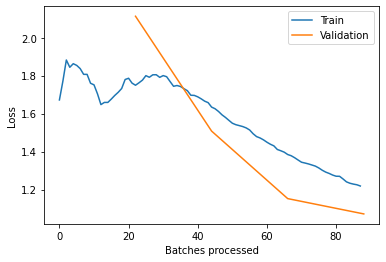

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# losses still going down
learn.fit_one_cycle(2)
learn.save('stage-1.5')

epoch,train_loss,valid_loss,accuracy,time
0,0.966422,1.123954,0.564738,00:03
1,0.972124,1.016060,0.592287,00:03


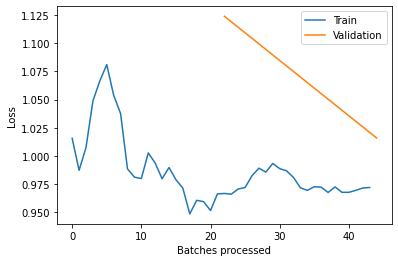

In [ ]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.74E-04


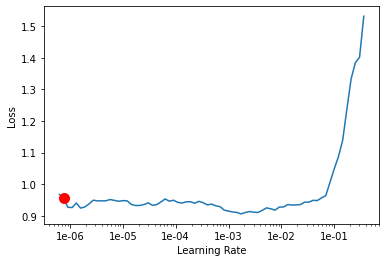

In [ ]:
learn.load('stage-1.5')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.874938,0.978433,0.589532,00:03
1,0.874821,0.917570,0.611570,00:03
2,0.838180,0.921829,0.592287,00:03
3,0.799059,0.870517,0.617080,00:03
4,0.777763,0.856529,0.622590,00:03
5,0.742215,0.847104,0.622590,00:03


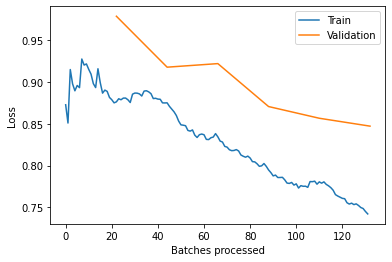

In [ ]:
learn.recorder.plot_losses()

In [ ]:
(PATH36/'models').ls()

[PosixPath('/content/drive/My Drive/datasets/pizza_doneness/imgs_36x36/models/stage-1.pth'),
 PosixPath('/content/drive/My Drive/datasets/pizza_doneness/imgs_36x36/models/stage-1.5.pth'),
 PosixPath('/content/drive/My Drive/datasets/pizza_doneness/imgs_36x36/models/tmp.pth'),
 PosixPath('/content/drive/My Drive/datasets/pizza_doneness/imgs_36x36/models/stage-2.pth')]

### training on size 128

In [ ]:
gc.collect()

learn = cnn_learner(data128, 
                    models.resnet50, 
                    metrics=accuracy, 
                    train_bn=True)

# load weights from previous training
learn = learn.load(PATH36/'models'/'stage-2')

weights = (sklearn.utils
                  .class_weight
                  .compute_class_weight('balanced', 
                                        np.array(['light', 'medium', 'dark']), 
                                        np.array(df['labeled_class'])))

# set same loss as before
class_weights = torch.FloatTensor(weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.832110,0.707084,0.707989,00:06
1,0.736379,0.668900,0.713499,00:05
2,0.673805,0.597802,0.719008,00:05
3,0.614256,0.585691,0.727273,00:05


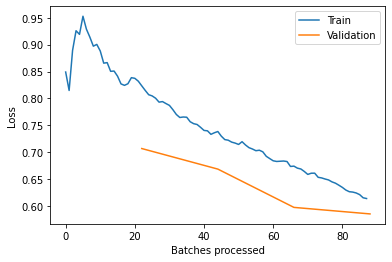

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(2)
learn.save('stage-1.5')

epoch,train_loss,valid_loss,accuracy,time
0,0.565149,0.649551,0.738292,00:05
1,0.546040,0.603673,0.732782,00:05


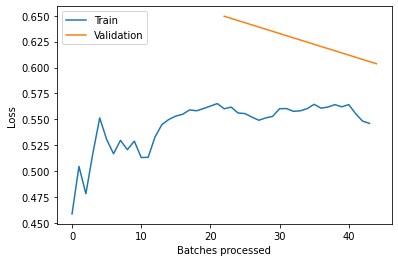

In [ ]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-04


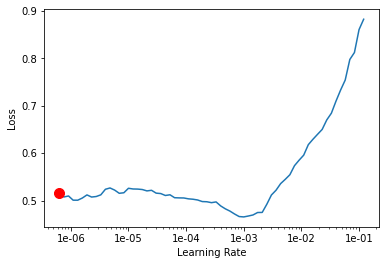

In [ ]:
learn.load('stage-1.5')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.519350,0.576080,0.760331,00:05
1,0.504538,0.541687,0.757576,00:05
2,0.451090,0.557930,0.774105,00:05
3,0.403923,0.528309,0.782369,00:05
4,0.366751,0.511708,0.782369,00:05
5,0.342420,0.514413,0.785124,00:05


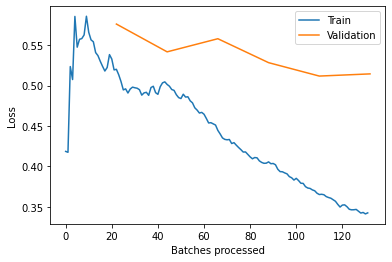

In [ ]:
learn.recorder.plot_losses()

### training on size 256

In [ ]:
gc.collect()

learn = cnn_learner(data256, 
                    models.resnet50, 
                    metrics=accuracy, 
                    train_bn=True)

# load weights from previous training
learn = learn.load(PATH128/'models'/'stage-2')

weights = (sklearn.utils
                  .class_weight
                  .compute_class_weight('balanced', 
                                        np.array(['light', 'medium', 'dark']), 
                                        np.array(df['labeled_class'])))

# set same loss as before
class_weights = torch.FloatTensor(weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.427552,0.348963,0.867769,00:14
1,0.412773,0.362827,0.851240,00:13
2,0.367316,0.340590,0.873278,00:13
3,0.338029,0.337372,0.867769,00:13


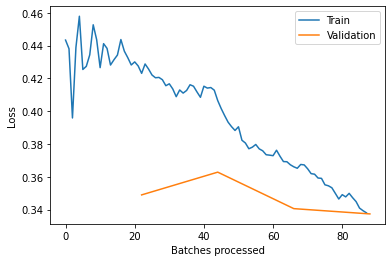

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(2)
learn.save('stage-1.5')

epoch,train_loss,valid_loss,accuracy,time
0,0.286549,0.369680,0.856749,00:13
1,0.278551,0.395305,0.848485,00:13


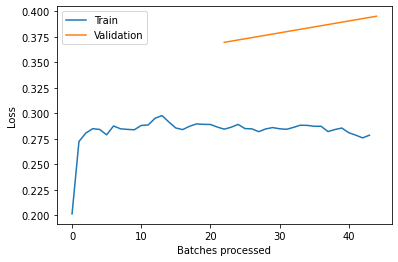

In [ ]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 9.12E-06


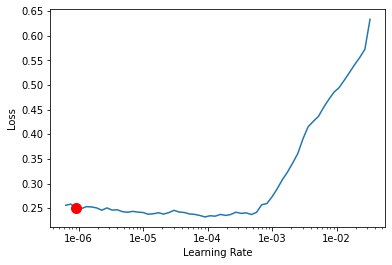

In [ ]:
learn.load('stage-1.5')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.269625,0.362940,0.859504,00:14
1,0.239984,0.397535,0.845730,00:14
2,0.216173,0.361866,0.845730,00:14
3,0.202127,0.361722,0.848485,00:14
4,0.166672,0.393977,0.834711,00:14


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.export(file=Path('/content/export.pkl'))

### training on size 512

In [ ]:
gc.collect()

learn = cnn_learner(data512, 
                    models.resnet50, 
                    metrics=accuracy, 
                    train_bn=True)

learn = learn.load(PATH256/'models'/'stage-2')

weights = (sklearn.utils
                  .class_weight
                  .compute_class_weight('balanced', 
                                        np.array(['light', 'medium', 'dark']), 
                                        np.array(df['labeled_class'])))

class_weights = torch.FloatTensor(weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learn.export(file=Path('/content/pizza_doneness_dynamic_weighted_loss_resnet50.pkl'))

In [ ]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(2)
learn.save('stage-1.5')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load('stage-1.5')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))
learn.save('stage-2')

In [ ]:
learn.recorder.plot_losses()